___
# <center> Import Python Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

___
## <center> Reading in our Saved CSV File
    
___

In [2]:
final_df = pd.read_csv('ModellingNewCarSales_Web.csv')
final_df.head(2)

,Price,Age,Engine_Durability,Model_Honda/Volvo/Ford,Model_Isuzu/MG,Model_Jeep/Skoda,Model_Kia/Audi/Maz/Mini/Suz/Land/VW,Model_LDV/GWM,Model_Lexus/BMW,Model_Mit/Hyun/Benz/Ren/Nis/Sub/Toy,Body_Coupe/Convertible,Body_Hatchback,Body_Sedan,Body_Wagon,Transmission_Manual,Drive_AWD,Drive_Rear,Fuel_type_Hybrid,Fuel_type_LPG,Fuel_type_Unleaded
0,15500.0,6,100.82,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,6499.0,17,182.25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


___
## <center> XGBoost Model
    
___

In [11]:
import xgboost as xgb


steps =[('scaler', StandardScaler()),
       ("xgb", xgb.XGBRegressor(min_child_weight=2,
                               n_jobs = -1))]

xgb_pipeline = Pipeline(steps)

___
## <center> Splitting the dataset into training and validation
    
___

In [23]:
# Create X,y variables
X = final_df.drop(['Price'],axis =1).values
y = final_df['Price'].values

# Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)
print('Training dataset: X_train=', X_train.shape, ', y_train', y_train.shape)
print('\nTesting dataset: X_test=', X_test.shape, ', y_test', y_test.shape)

Training dataset: X_train= (8431, 19) , y_train (8431,)

Testing dataset: X_test= (2811, 19) , y_test (2811,)


___
## <center> Hyper-Parameter Tunning
___

In [20]:
from sklearn.model_selection import RandomizedSearchCV,KFold

cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'xgb__n_estimators': np.arange(50,301,50),
    'xgb__max_depth': [3,5,6],
    'xgb__min_child_weight': [2,3,5],
}

# Perform grid search: grid_mse
xgb_grid_mse = RandomizedSearchCV(estimator=xgb_pipeline, 
                        param_distributions=gbm_param_grid,
                        n_jobs = -1,
                        scoring='neg_mean_squared_error', 
                        cv=cv_inner, 
                        verbose=1)

xgb_grid_mse.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_grid_mse.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.9s finished


Best parameters found:  {'xgb__n_estimators': 150, 'xgb__min_child_weight': 3, 'xgb__max_depth': 6}


___
## <center> Model Performance – Evaluation
___

In [21]:
# Fit pipeline
xgb_pipeline.fit(X_train,y_train)


# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = xgb_pipeline.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = xgb_pipeline.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train_pred,y_train)
MSE_test = mean_squared_error(y_test_pred,y_test)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train_pred,y_train))
RMSE_test=np.sqrt(mean_squared_error(y_test_pred,y_test))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in testing for RMSE: {RMSE_test}')

The naive MSE baseline is  87854221.54696502
The naive RMSE baseline is  9373.058281423679

The model performance in training for MSE: 7718790.841204636
The model performance in training for RMSE: 2778.27119648256

The model performance in testing for MSE: 10882949.007300803
The model performance in testing for RMSE: 3298.931494787487


___
## <center> Tunned Model Performance – Evaluation
___

In [22]:
# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = xgb_grid_mse.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = xgb_grid_mse.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in testing for RMSE: {RMSE_test}')

The naive MSE baseline is  87854221.54696502
The naive RMSE baseline is  9373.058281423679

The model performance in training for MSE: 7155989.196914049
The model performance in training for RMSE: 2675.068073323378

The model performance in testing for MSE: 10578840.281125313
The model performance in testing for RMSE: 3252.512917902912


___
## <center> Model Performance – Plotting
___

<AxesSubplot:xlabel='true', ylabel='predicted'>

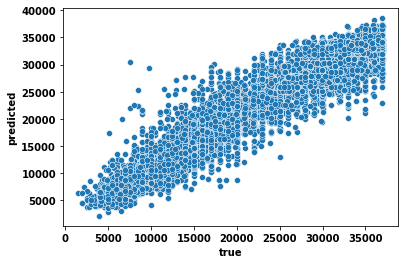

In [57]:
plotting_df = pd.DataFrame()
plotting_df['predicted'] = xgb_grid_mse.predict(X)
plotting_df['true'] = y
sns.scatterplot(x = 'true', y = 'predicted', data = plotting_df)

___
## <center> XGBoost Feature Importance
___

In [58]:
XGB = xgb.XGBRegressor(n_jobs = -1).fit(X_train,y_train)
feature_importance = pd.DataFrame({'Importance':XGB.feature_importances_, 'features':final_df.columns[1:]})
feature_importance = feature_importance.sort_values(by = ['Importance'])

Text(0.5, 1.0, 'XGBoost Feature Importance')

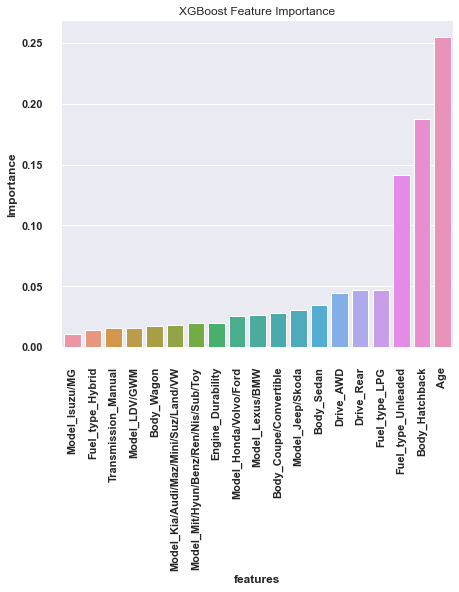

In [59]:

sns.set_theme(palette="pastel")

fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(x = 'features',y = 'Importance',data = feature_importance )
sns.despine(offset=10,right=True,
                bottom=False)# Despine
ax.xaxis.grid(False)# Add gridlines
plt.xticks(rotation=90)
plt.title('XGBoost Feature Importance')


___
# <center> Saving Model & Loading Model
___

In [95]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(xgb_grid_mse, open(filename, 'wb'))


In [27]:
# Load the Model back from file
with open('finalized_model.sav', 'rb') as file:  
    XGBoost_model = pickle.load(file)

XGBoost_model

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           gamma=0, gpu_id=-1,
                                                           importance_type='gain',
                                                           interaction_constraints='',
                                                           learning_rate=0.300000012,
                                                           max_delta_step=0,